# Lab10 : Take Home Exercise

## st121411

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from tqdm import tqdm
import os

In [2]:
train_cat_path = glob.glob("./train/cat*")
train_dog_path = glob.glob("./train/dog*")

assert len(train_cat_path) == len(train_dog_path)

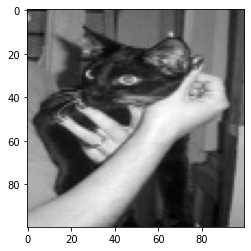

In [3]:
IMAGE_SIZE = 100
image = cv2.imread(train_cat_path[0])
resized_image = cv2.resize(image,(100,100))
grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

plt.imshow(grayscaled_image,cmap='gray')
plt.show()

In [4]:
if not (os.path.exists('train.npy') and os.path.exists('train_label.npy')):
    train_cat = []
    train_dog = []
    label_cat = []
    label_dog = []

    for cat_path in tqdm(train_cat_path):
        image = cv2.imread(cat_path)
        resized_image = cv2.resize(image,(100,100))
        grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        train_cat.append(grayscaled_image[np.newaxis,:,:])
        label_cat.append(0)

    for dog_path in tqdm(train_dog_path):
        image = cv2.imread(dog_path)
        resized_image = cv2.resize(image,(100,100))
        grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        train_dog.append(grayscaled_image[np.newaxis,:,:])
        label_dog.append(1)

    train = train_cat + train_dog
    train_label = label_cat + label_dog
    
    data = np.array(train).astype(np.float)/256
    data_label = np.array(train_label).astype(np.float)

    np.save('train.npy',data)
    np.save('train_label.npy',data_label)
else:
    data = np.load('train.npy')
    data_label = np.load('train_label.npy')
    
idx = np.arange(data.shape[0])
np.random.shuffle(idx)
TRAIN_PERCENT = 0.7

train = data[idx[:int(idx.size*TRAIN_PERCENT)]] 
train_label = data_label[idx[:int(idx.size*TRAIN_PERCENT)]]

test = data[idx[int(idx.size*TRAIN_PERCENT):]]
test_label = data_label[idx[int(idx.size*TRAIN_PERCENT):]]

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [6]:
train = torch.Tensor(train)
train_label = torch.Tensor(train_label).long()

train_dataset = TensorDataset(train,train_label)
train_dataloader = DataLoader(train_dataset,batch_size=200,shuffle=True)

test = torch.Tensor(test)
test_label = torch.Tensor(test_label).long()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(6400,500)
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,2)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
      #  print(x.flatten(start_dim = 1).shape)
        x = x.view(-1,6400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [9]:
net = Net().to(device)

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [14]:
import time
from IPython.display import clear_output, display

EPOCHS = 400

train_loss = []
validation_loss = []
validation_acc = []

for epoch in range(EPOCHS):
    for i,data in enumerate(train_dataloader):

        batch_X,batch_y = data
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        #print(batch_y)
        net.zero_grad()
        outputs = net(batch_X)
        #print(outputs[0])
        loss = criterion(outputs,batch_y)

        loss.backward()
        optimizer.step()
        
        if i % 2 == 0:
            train_loss.append(loss.item())
            with torch.no_grad():
                VAL_SIZE = 200
                idx = np.arange(test.shape[0])
                np.random.shuffle(idx)
                val_X = test[idx[:VAL_SIZE]].to(device)
                val_y = test_label[idx[:VAL_SIZE]].to(device)
                prediction = net(val_X)
                val_loss = criterion(prediction,val_y)
                validation_loss.append(val_loss.item())
                prediction = torch.argmax(prediction,dim=1)
                val_acc = (prediction == val_y).sum()/float(VAL_SIZE)
                validation_acc.append(val_acc)

            clear_output(wait=True)
            print(f"Epochs: {epoch} train_loss: {loss} val_loss: {val_loss} val_acc: {val_acc}")

Epochs: 0 train_loss: 0.6933808922767639 val_loss: 0.6932234764099121 val_acc: 0.4949999749660492
Epochs: 0 train_loss: 0.6926403045654297 val_loss: 0.690494179725647 val_acc: 0.5799999833106995
Epochs: 0 train_loss: 0.6948318481445312 val_loss: 0.6923151612281799 val_acc: 0.5199999809265137
Epochs: 0 train_loss: 0.6927888989448547 val_loss: 0.6924486756324768 val_acc: 0.5199999809265137
Epochs: 0 train_loss: 0.6931214332580566 val_loss: 0.6928417682647705 val_acc: 0.47999998927116394
Epochs: 0 train_loss: 0.693101704120636 val_loss: 0.6924211382865906 val_acc: 0.5099999904632568
Epochs: 0 train_loss: 0.6923015713691711 val_loss: 0.6928970217704773 val_acc: 0.4949999749660492
Epochs: 0 train_loss: 0.6935588121414185 val_loss: 0.6894019246101379 val_acc: 0.5949999690055847
Epochs: 0 train_loss: 0.6916384100914001 val_loss: 0.6917375922203064 val_acc: 0.5149999856948853
Epochs: 1 train_loss: 0.6923170685768127 val_loss: 0.6926429271697998 val_acc: 0.48499998450279236
Epochs: 1 train_loss

KeyboardInterrupt: 

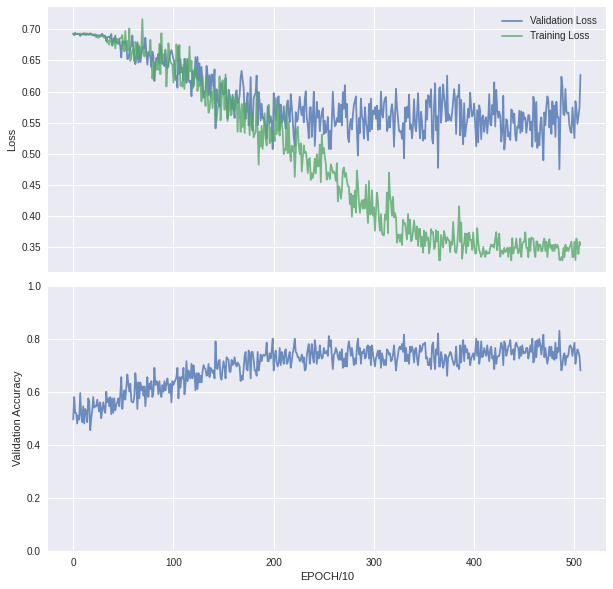

In [15]:
epoch_series = range(len(validation_loss))

plt.style.use('seaborn')

fig,ax = plt.subplots(2,1,figsize=(10,10),sharex=True)
plt.subplots_adjust(hspace=0.05)

ax[0].plot(epoch_series,validation_loss,label="Validation Loss",alpha=0.8)
ax[0].plot(epoch_series,train_loss, label="Training Loss",alpha=0.8)
ax[0].legend()
ax[0].grid(True)
ax[0].set_ylabel("Loss")

ax[1].plot(epoch_series,validation_acc,alpha=0.8)
ax[1].set_ylim([0,1])
ax[1].grid(True)
ax[1].set_ylabel("Validation Accuracy")
ax[1].set_xlabel("EPOCH/10")

plt.show()

- The model has 2 convolutional layer and 3 fully connnected layer. The loss function is the binary cross entropy and SGD was used as the optimizer. 
- Initially the EPOCH was set to be 400 but since the validation loss was becoming larger the training was halted prematurely. 
- From the graph above, it could be seen that the validation accuracy goes up to approximately 70-80%. 
- Interestingly, even though the model started to overfit, the accuracy did not become significantly worse, and visually it is even quite difficult to see whether the accuracy dropped or not.
- This exercise helped me learn how to preprocess data, design a model, as well as train a model.